In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def display_confusion_matrix(y_pred, y_actual):
    cm = confusion_matrix(y_actual, y_pred)

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create a heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

    # Set labels, title, and ticks
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Non-CVD', 'CVD'])
    ax.yaxis.set_ticklabels(['Non-CVD', 'CVD'])

    # Calculate and display other metrics if needed
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    print("Accuracy:", accuracy)
    print("Sensitivity/Recall:", recall)
    print("Specificity:", specificity)

    return cm, accuracy, recall, specificity

In [ ]:
# Function for DNN performance
def model_performance_DNN(x, model, y):
    hypo = model.predict(x)
    pred = np.where(hypo > 0.5, 1, 0).flatten() # relation to sigmoid activation function
    cm, accuracy, recall, specificity=display_confusion_matrix(pred, y)
    auc = roc_auc_score(y, hypo)

    print("AUC : ",auc)
    plt.show()
    return accuracy ,recall, specificity ,auc

In [ ]:
#LOAD DATASET
framingham=pd.read_csv('/content/drive/MyDrive/TFG/framingham.csv')
framingham = framingham[framingham['glucose'] <= 250] #There are outliers in glucose
# We are filling the NaN values with the mean
data_filled = framingham.fillna(framingham.mean())

In [ ]:
#Change to int the variables that have values of 0 or 1 as they are categorical
columns_to_convert = ['BPMeds']
data_filled['BPMeds'] = data_filled['BPMeds'].astype(int)

In [ ]:
#PREPARE THE DATA AGAIN
# Import the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler


# Data prep
data_x = data_filled.drop(columns=['TenYearCHD','education','BPMeds','prevalentStroke'])
data_y = data_filled.TenYearCHD

# Separate into training and test data
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.3, random_state=42, stratify=data_y)

# Apply oversampling
ros = RandomOverSampler(sampling_strategy=0.9)
train_x_oversampled, train_y_oversampled = ros.fit_resample(train_x, train_y)

# Normalize the data
sc = StandardScaler()
x_train = sc.fit_transform(train_x_oversampled)
x_test=sc.transform(test_x)


# Now we can use train_x_oversampled and train_y_oversampled for model training

In [ ]:
train_y_oversampled.value_counts()

0    2276
1    2048
Name: TenYearCHD, dtype: int64

In [ ]:
#MODEL AGAIN
DNN = keras.Sequential(name="DNN")
DNN.add(keras.layers.Dense(64, input_dim=12,kernel_regularizer= keras.regularizers.l2(0.01), activation='elu', name="dense_1"))
DNN.add(keras.layers.Dense(64,kernel_regularizer= keras.regularizers.l2(0.01), activation='elu', name="dense_2"))
DNN.add(keras.layers.Dense(32,kernel_regularizer= keras.regularizers.l2(0.01), activation='elu', name="dense_3"))
DNN.add(keras.layers.Dense(32,kernel_regularizer= keras.regularizers.l2(0.01), activation='elu', name="dense_4"))
DNN.add(keras.layers.Dense(1, activation='sigmoid', name="output"))

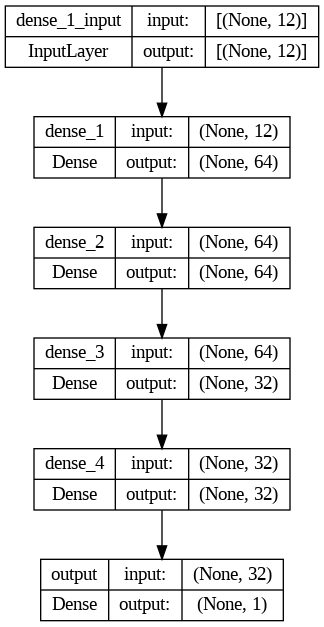

In [ ]:
from keras.utils import plot_model
plot_model(DNN, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
#LETS COMPILE AND FIT THE DNN MODEL WITHT HIS NEW DATA
# Compile
DNN.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy', metrics=['AUC'])

history = DNN.fit(x_train, train_y_oversampled, batch_size=70, epochs=200)
train_loss = history.history['loss']

Epoch 1/200
62/62 [==============================] - 2s 3ms/step - loss: 2.2311 - auc: 0.6283
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 2.1269 - auc: 0.7084
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 2.0485 - auc: 0.7221
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 1.9780 - auc: 0.7284
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 1.9125 - auc: 0.7310
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 1.8503 - auc: 0.7329
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 1.7907 - auc: 0.7348
Epoch 8/200
62/62 [==============================] - 0s 3ms/step - loss: 1.7335 - auc: 0.7357
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 1.6790 - auc: 0.7362
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 1.6268 - auc: 0.7365
Epoch 11/200
62/62 [==============================] - 0s 2m

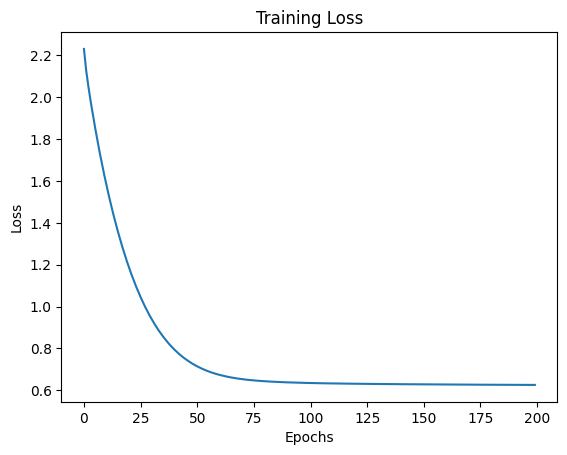

In [ ]:
# Plot the training loss
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

36/36 [==============================] - 0s 1ms/step
Accuracy: 0.7026086956521739
Sensitivity/Recall: 0.7068965517241379
Specificity: 0.701844262295082
AUC :  0.7452539099302808


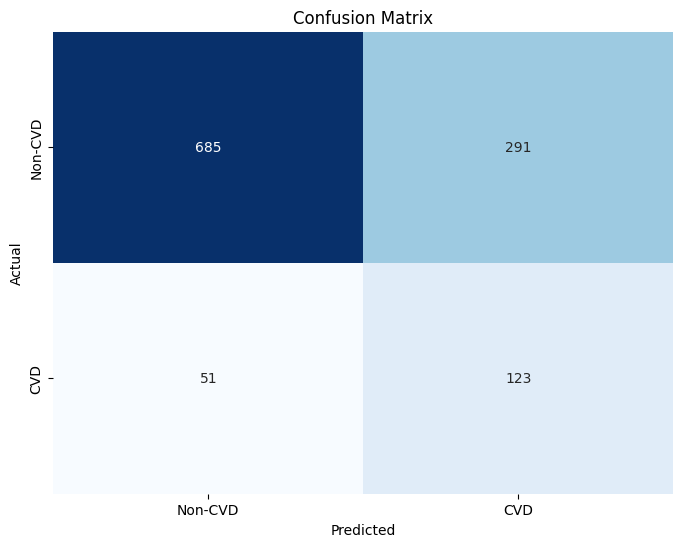

(0.7026086956521739, 0.7068965517241379, 0.701844262295082, 0.7452539099302808)

In [ ]:
# Prediction using validation data --> SHOW LOSS FUNCTION IF WE DO DNN
test_actual_value = test_y.values
model_performance_DNN(x_test, DNN, test_actual_value)

In [ ]:
DNN.save('/content/drive/MyDrive/TFG/oversampling_random_07449AUC.h5')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/TFG/oversampling_random_07449AUC.h5')